In [1]:
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType

In [2]:
# Initiaize spark environment
conf = pyspark.SparkConf().setAppName('odl').setMaster('local')
sc = pyspark.SparkContext(conf=conf)
sqlc = pyspark.sql.SQLContext(sc)
sc

<SparkContext master=local appName=odl>

In [3]:
# setup a sample dataframe
role = get_execution_role()
bucket='odl-spark19spds6003-001'
data_key = 'as3ek/train.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pddf = pd.read_csv(data_location)

In [4]:
pddf = pddf.dropna()

In [5]:
df = sqlc.createDataFrame(pddf)

In [6]:
parquetPath = '/home/ec2-user/SageMaker/Open-Data-Lab/education/as3ek/'
df.write.parquet(parquetPath)

In [7]:
df = sqlc.read.parquet(parquetPath)

In [8]:
display(df)

DataFrame[PassengerId: bigint, Survived: bigint, Pclass: bigint, Name: string, Sex: string, Age: double, SibSp: bigint, Parch: bigint, Ticket: string, Fare: double, Cabin: string, Embarked: string]

In [9]:
df.printSchema()

root
 |-- PassengerId: long (nullable = true)
 |-- Survived: long (nullable = true)
 |-- Pclass: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: long (nullable = true)
 |-- Parch: long (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [10]:
df = df.withColumn("Age", df["Age"].cast(IntegerType()))

In [11]:
df.printSchema()

root
 |-- PassengerId: long (nullable = true)
 |-- Survived: long (nullable = true)
 |-- Pclass: long (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- SibSp: long (nullable = true)
 |-- Parch: long (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [12]:
df.take(2)

[Row(PassengerId=2, Survived=1, Pclass=1, Name='Cumings, Mrs. John Bradley (Florence Briggs Thayer)', Sex='female', Age=38, SibSp=1, Parch=0, Ticket='PC 17599', Fare=71.2833, Cabin='C85', Embarked='C'),
 Row(PassengerId=4, Survived=1, Pclass=1, Name='Futrelle, Mrs. Jacques Heath (Lily May Peel)', Sex='female', Age=35, SibSp=1, Parch=0, Ticket='113803', Fare=53.1, Cabin='C123', Embarked='S')]

In [13]:
# Take two features for analysis
df = df.select("Age","Survived")

In [14]:
# create train/test sets
seed = 42
(testDF, trainingDF) = df.randomSplit((0.20, 0.80), seed=seed)
print ('training set N = {}, test set N = {}'.format(trainingDF.count(),testDF.count()))

training set N = 143, test set N = 40


In [15]:
from pyspark.ml.linalg import Vectors, VectorUDT

# make a user defined function (udf)
sqlc.registerFunction("oneElementVec", lambda d: Vectors.dense([d]), returnType=VectorUDT())

# vectorize the data frames
trainingDF = trainingDF.selectExpr("Survived", "oneElementVec(Age) as Age")
testDF = testDF.selectExpr("Survived", "oneElementVec(Age) as Age")

print(trainingDF.orderBy(trainingDF.Age.desc()).limit(5))

DataFrame[Survived: bigint, Age: vector]


In [16]:
# Renaming columns for happiness
trainingDF = trainingDF.withColumnRenamed("Survived", "label").withColumnRenamed("Age", "features")
testDF = testDF.withColumnRenamed("Survived", "label").withColumnRenamed("Age", "features")

In [17]:
from pyspark.ml.classification import *

lr = LogisticRegression()
lrModel = lr.fit(trainingDF)

In [18]:
type(lrModel)

pyspark.ml.classification.LogisticRegressionModel

In [19]:
predictionsAndLabelsDF = lrModel.transform(testDF)

print(predictionsAndLabelsDF.orderBy(predictionsAndLabelsDF.label.desc()).take(5))

[Row(label=1, features=DenseVector([4.0]), rawPrediction=DenseVector([-2.0492, 2.0492]), probability=DenseVector([0.1141, 0.8859]), prediction=1.0), Row(label=1, features=DenseVector([4.0]), rawPrediction=DenseVector([-2.0492, 2.0492]), probability=DenseVector([0.1141, 0.8859]), prediction=1.0), Row(label=1, features=DenseVector([11.0]), rawPrediction=DenseVector([-1.7579, 1.7579]), probability=DenseVector([0.147, 0.853]), prediction=1.0), Row(label=1, features=DenseVector([14.0]), rawPrediction=DenseVector([-1.6331, 1.6331]), probability=DenseVector([0.1634, 0.8366]), prediction=1.0), Row(label=1, features=DenseVector([17.0]), rawPrediction=DenseVector([-1.5083, 1.5083]), probability=DenseVector([0.1812, 0.8188]), prediction=1.0)]


In [20]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
eval = BinaryClassificationEvaluator()
print(eval.explainParams())

labelCol: label column name. (default: label)
metricName: metric name in evaluation (areaUnderROC|areaUnderPR) (default: areaUnderROC)
rawPredictionCol: raw prediction (a.k.a. confidence) column name. (default: rawPrediction)


In [21]:
eval.setMetricName("areaUnderROC").evaluate(predictionsAndLabelsDF)

0.6206896551724137

In [22]:
eval.setMetricName("areaUnderPR").evaluate(predictionsAndLabelsDF)

0.8260019944327422

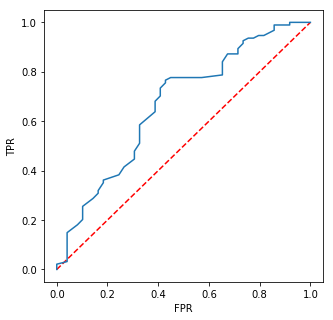

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lrModel.summary.roc.select('FPR').collect(),
         lrModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()